## **Loading data**

In [1]:
!mkdir Data
!mkdir Data/baseline_catboost

!wget https://storage.yandexcloud.net/datasouls-ods/materials/0433a4ca/transactions.zip -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/0554f0cf/clickstream.zip -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/acfacf11/train_matching.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/b949c04c/mcc_codes.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/705abbab/click_categories.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/e33f2201/currency_rk.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/b99fed70/puzzle.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/f76e8087/sample_submission.csv -P Data
!wget https://storage.yandexcloud.net/datasouls-ods/materials/24687252/baseline_catboost.zip -P Data
    
!unzip Data/transactions.zip -d Data
!unzip Data/clickstream.zip -d Data
!unzip Data/baseline_catboost.zip -d Data/baseline_catboost

!rm Data/transactions.zip
!rm Data/clickstream.zip
!rm Data/baseline_catboost.zip

A subdirectory or file Data already exists.
The syntax of the command is incorrect.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program 

## **Import libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle
import sys
import warnings
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder

colors = sns.cubehelix_palette(start=.5, rot=-.5)
palette = plt.get_cmap('cubehelix')
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings('ignore')

In [3]:
# вспомогательная функция для контроля за памятью

from psutil import virtual_memory
ram_gb = round(virtual_memory().total / 1024**3, 1)
def print_memory():
    print('memory used', round(virtual_memory().used/1024/1024/1024,2), 'Gb', end = ' | ')
    print('memory available', round(virtual_memory().available/1024/1024/1024,2), 'Gb', end = ' | ')
    print('memory available', round(virtual_memory().available * 100 / virtual_memory().total,2), 'percent')

In [4]:
all_dicts = {}

In [5]:
print_memory()

memory used 5.35 Gb | memory available 6.55 Gb | memory available 55.04 percent


## **Reading and proccesing data**

### **Main files**

In [6]:
# reading data
transactions = pd.read_csv('C:/Coding/Python/VTB/Data/transactions.csv')
clickstream = pd.read_csv('C:/Coding/Python/VTB/Data/clickstream.csv')

In [7]:
print('Transactions:\n',transactions.dtypes, '\n', '\nClickstream:\n', clickstream.dtypes)

Transactions:
 user_id              object
mcc_code              int64
currency_rk           int64
transaction_amt     float64
transaction_dttm     object
dtype: object 
 
Clickstream:
 user_id      object
cat_id        int64
timestamp    object
new_uid       int64
dtype: object


In [8]:
# transform "object" for transaction_dttm, timestamp to datetime type

transactions['transaction_dttm'] = pd.to_datetime(transactions['transaction_dttm'])
clickstream['timestamp'] = pd.to_datetime(clickstream['timestamp'])

#### **Clickstream**

In [9]:
print('Shape of clickstream: ', clickstream.shape)
clickstream.head(2)

Shape of clickstream:  (126752515, 4)


,user_id,cat_id,timestamp,new_uid
0,000143baebad4467a23b98c918ccda19,165,2021-01-30 20:08:12,1873448
1,000143baebad4467a23b98c918ccda19,165,2021-01-31 20:06:29,1873448


In [10]:
for col in clickstream:
    print(col, '\t', clickstream[col].nunique(), '\t', clickstream[col].min(), ' - ', clickstream[col].max())

user_id 	 19623 	 000143baebad4467a23b98c918ccda19  -  ffff8348710b49c78ffa8c13b00b22f4
cat_id 	 402 	 1  -  1861
timestamp 	 5840311 	 2021-01-17 18:42:39  -  2021-08-14 22:41:59
new_uid 	 81285 	 21  -  1873964


*In file clickstream.csv 126.7 millions rows, 19623 unique clients, 402 unique categories and 81285 unique devices. Time - mid-January to mid-August 2021*

In [11]:
# data reduction by encoding
all_dicts['rtk_le'] = LabelEncoder().fit(clickstream['user_id'])
clickstream['user_id'] = all_dicts['rtk_le'].transform(clickstream['user_id'])+1
clickstream_dtypes = {'user_id':np.int16, 'cat_id':np.int16, 'new_uid':np.int32}
clickstream = clickstream.astype(clickstream_dtypes)

In [12]:
print('For each RTC user, there is ', round(clickstream.shape[0] / clickstream['user_id'].nunique(),1), ' unique entries')
print('For each RTC user, there is ', round(clickstream['new_uid'].nunique() / clickstream['user_id'].nunique(),1), ' unique devices')

For each RTC user, there is  6459.4  unique entries
For each RTC user, there is  4.1  unique devices


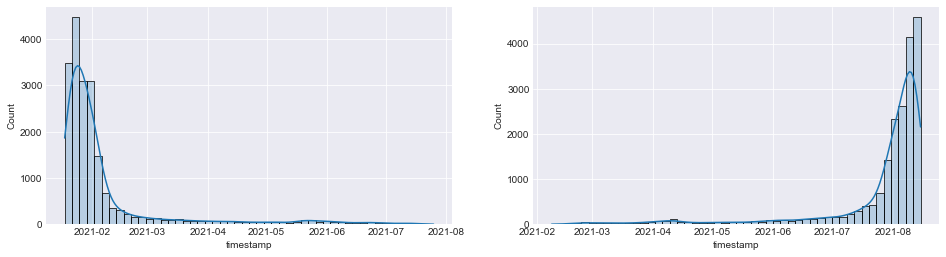

In [13]:
# Let's look at the distribution of the start and end times of customer activity
fig, axes = plt.subplots(1,2, figsize = (16,4))
sns.histplot(clickstream.groupby('user_id')['timestamp'].min(), bins= 50, ax = axes[0], kde = True, alpha = 0.25, palette = palette)
sns.histplot(clickstream.groupby('user_id')['timestamp'].max(), bins= 50, ax = axes[1], kde = True, alpha = 0.25, palette = palette);

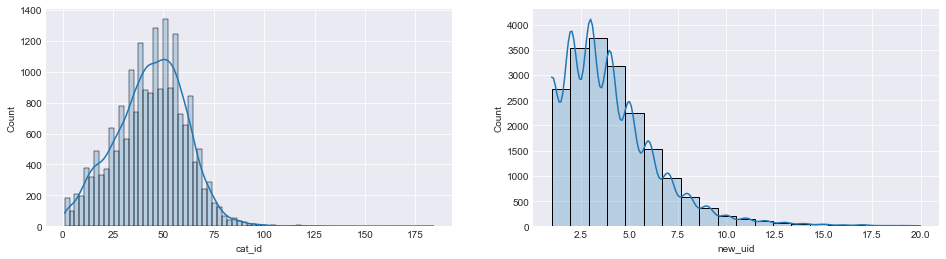

In [14]:
# Let's look at the distribution of the number of unique categories and devices for each client
fig, axes = plt.subplots(1,2, figsize = (16,4))
sns.histplot(clickstream.groupby('user_id')['cat_id'].agg(pd.Series.nunique), palette=palette, kde = True, alpha = 0.25, bins = 75, ax = axes[0])
t = clickstream.groupby('user_id')['new_uid'].agg(pd.Series.nunique)
sns.histplot(t[t<21],bins=20,palette=palette, kde = True, alpha = 0.25, ax = axes[1]);

In [15]:
print('Clickstream by cat_id info:\n', clickstream.groupby('user_id')['cat_id'].agg(pd.Series.nunique).describe(), '\n')
print('Clickstream by new_uid info:\n', clickstream.groupby('user_id')['new_uid'].agg(pd.Series.nunique).describe())

Clickstream by cat_id info:
 count    19623.000000
mean        43.679254
std         17.641016
min          1.000000
25%         32.000000
50%         45.000000
75%         56.000000
max        184.000000
Name: cat_id, dtype: float64 

Clickstream by new_uid info:
 count    19623.000000
mean         4.142333
std          5.156828
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        419.000000
Name: new_uid, dtype: float64


#### **Transactions**

In [16]:
print('Shape of transactions: ', transactions.shape)
transactions.head(2)

Shape of transactions:  (19821910, 5)


,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.07230,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.31398,2020-08-05 01:27:40


In [17]:
for col in transactions:
    print(col, '\t', transactions[col].nunique(), '\t', transactions[col].min(), ' - ', transactions[col].max())

user_id 	 22533 	 000932580e404dafbecd5916d4640938  -  fffb051877b949f49bed6538393a06ae
mcc_code 	 386 	 -1  -  9406
currency_rk 	 4 	 -1  -  60
transaction_amt 	 17063000 	 -230044.03  -  346395.34
transaction_dttm 	 12787367 	 2020-07-17 18:59:38  -  2021-08-14 21:13:26


*In file transactions.csv 19.8 millions rows, 22533 unique clients, 386 unique mcc_codes and 4 unique currencies. Time - mid-July 2020 to mid-August 2021*

In [18]:
# data size reduction by encoding
all_dicts['bank_le'] = LabelEncoder().fit(transactions['user_id'])
transactions['user_id'] = all_dicts['bank_le'].transform(transactions['user_id'])+1
transactions_dtypes = {'user_id':np.int16, 'mcc_code':np.int16, 'currency_rk':np.int8}
transactions = transactions.astype(transactions_dtypes)

In [19]:
print('For each bank user, there is ', round(transactions.shape[0] / transactions['user_id'].nunique(),1), ' unique entries')

For each bank user, there is  879.7  unique entries


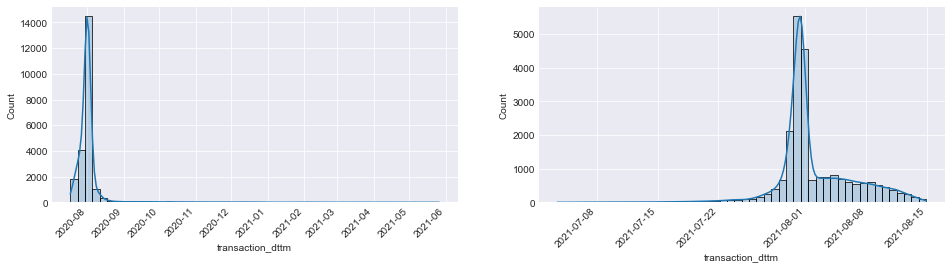

In [20]:
# Let's look at the distribution of the start and end times of customer activity
fig, axes = plt.subplots(1,2, figsize = (16,4))
fig.autofmt_xdate(rotation=45 )
sns.histplot(transactions.groupby('user_id')['transaction_dttm'].min(), bins= 50, ax = axes[0], kde = True, alpha = 0.25, palette = palette)
sns.histplot(transactions.groupby('user_id')['transaction_dttm'].max(), bins= 50, ax = axes[1], kde = True, alpha = 0.25, palette = palette);

In [21]:
# frequency of currency
transactions.currency_rk.value_counts()

 48    19765158
-1        27405
 50       20364
 60        8983
Name: currency_rk, dtype: int64

<AxesSubplot:xlabel='transaction_amt', ylabel='Count'>

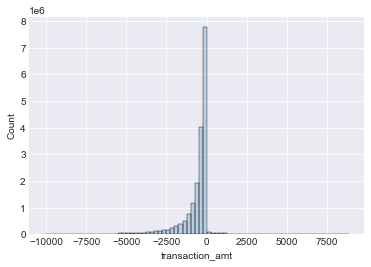

In [30]:
# Distribution transaction_amt
std = transactions['transaction_amt'].std()
mean = transactions['transaction_amt'].mean()
ind = (transactions['transaction_amt']>=mean-std)&(transactions['transaction_amt']<=mean+std)
data = transactions.loc[ind, 'transaction_amt']
sns.histplot( data, bins= 75, alpha = 0.25, palette = palette)

<AxesSubplot:xlabel='mcc_code', ylabel='Count'>

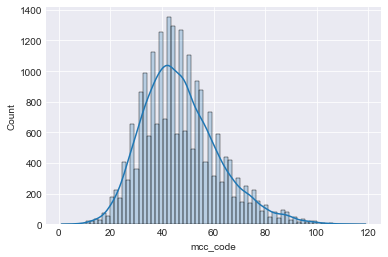

In [32]:
# Distribution unique  categories (mcc_codes)
sns.histplot(transactions.groupby('user_id')['mcc_code'].agg(pd.Series.nunique), palette=palette, kde = True, alpha = 0.25, bins = 75)

In [33]:
print('Transactions by mcc_code info:\n', transactions.groupby('user_id')['mcc_code'].agg(pd.Series.nunique).describe(), '\n')

Transactions by mcc_code info:
 count    22533.000000
mean        47.171393
std         14.893906
min          1.000000
25%         37.000000
50%         45.000000
75%         56.000000
max        119.000000
Name: mcc_code, dtype: float64 



### **Additional files**

#### **Categories**

In [34]:
click_categories = pd.read_csv('Data/click_categories.csv')
print(click_categories.shape)
click_categories.head(2)

(402, 4)


,cat_id,level_0,level_1,level_2
0,1,accessories,NaN,NaN
1,2,accessories,handbags,NaN


In [59]:
click_categories.fillna('', inplace=True)
for col in click_categories:
    print(f"{col:<10}",click_categories[col].nunique() )

cat_id     402
level_0    85
level_1    280
level_2    56


In [94]:
for i in range(5):
    print(
        'level_0:',f"{click_categories['level_0'].value_counts().index[i]:<20}",
        f"{click_categories['level_0'].value_counts()[i]:<10}",
        
        'level_1:',f"{click_categories['level_1'].value_counts().index[i]:<20}", '\t',
        f"{click_categories['level_1'].value_counts()[i]:<10}",

        'level_2:',f"{click_categories['level_2'].value_counts().index[i]:<20}", '\t',
        f"{click_categories['level_2'].value_counts()[i]:<10}",
    )


level_0: public_services      24         level_1:                      	 81         level_2:                      	 347       
level_0: health               23         level_1: school_education     	 6          level_2: body_treatments      	 1         
level_0: occupation           22         level_1: household_services   	 6          level_2: utilities_sector     	 1         
level_0: education            17         level_1: business_automation  	 4          level_2: orphanage            	 1         
level_0: cars                 15         level_1: farming              	 4          level_2: cigarettes           	 1         


#### **Mcc_code**

In [96]:
mcc = pd.read_csv('Data/mcc_codes.csv')
print(mcc.shape)
mcc.head(2)

(385, 3)


,MCC,Название,Описание
0,742,Ветеринарные услуги,Лицензированные специалисты в основном занимаю...
1,763,Сельскохозяйственные кооперативы,"Ассоциации и кооперативы, которые предоставляю..."


In [98]:
mcc.fillna('', inplace=True)
for col in mcc:
    print(f"{col:<10}",mcc[col].nunique() )

MCC        385
Название   378
Описание   290


In [101]:
for i in range(5):
    print(
        f"{mcc['Название'].value_counts().index[i]:<50}",
        f"{mcc['Название'].value_counts()[i]:<50}",
    )


Отели, мотели, курорты                             7                                                 
Денежные переводы                                  2                                                 
Ветеринарные услуги                                1                                                 
Квази-Кэш – Нефинансовые учреждения                1                                                 
Финансовые учреждения – торговля и услуги          1                                                 


#### **Currency**

In [106]:
currency = pd.read_csv('Data/currency_rk.csv')
print(currency.shape)
currency

(3, 2)


,currency_rk,Name
0,48,RUR
1,50,USD
2,60,EUR


#### **Sample puzzle submission, puzzle and train files**

In [115]:
# Read sample_submission
pd.set_option('max_colwidth', 120)
sub = pd.read_csv('Data/sample_submission.csv')
print(sub.shape)
sub.head(2)

(4952, 2)


,bank,rtk_list
0,6dd66e8624da427da6b558903a5772b8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,224a2325b44a4326bc539e3f1a6e713b,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [117]:
# Read puzzle
puzzle = pd.read_csv('Data/puzzle.csv')
print(puzzle.shape)
puzzle.head(2)

(4952, 2)


,bank,rtk
0,6dd66e8624da427da6b558903a5772b8,56f386b1a1a9455b9118cd290b0627d7
1,224a2325b44a4326bc539e3f1a6e713b,ca77a88196ef4dd786fb390340cf226e


In [118]:
# Label enconding
puzzle['bank'] = all_dicts['bank_le'].transform(puzzle['bank'])+1
puzzle['rtk'] = all_dicts['rtk_le'].transform(puzzle['rtk'])+1

In [120]:
train = pd.read_csv('Data/train_matching.csv')
print(train.shape)
train.head(2)

(17581, 2)


,bank,rtk
0,178b387813ac4a63a2200274a9e3876e,e19c0f141e9442c5bdb0d5751f6fba1c
1,47cffa46e6b04389ba91a70735d2c3ff,7df3371aabd349e4ac2de8299238627d


In [122]:
train['bank'] = all_dicts['bank_le'].transform(train['bank'])+1
train.loc[train.rtk=='0', 'rtk'] = 0
train.loc[train.rtk!=0, 'rtk'] = all_dicts['rtk_le'].transform(train.loc[train.rtk!=0, 'rtk'])+1

In [125]:
print('There are ', train.bank.nunique(), 'bank clients in the ''train'' file, of which', train.rtk.nunique(), 'have matches with RTK clients.')

There are  17581 bank clients in the train file, of which 14672 have matches with RTK clients.


In [23]:
# read additional data
train_matching = pd.read_csv('Data/train_matching.csv')
puzzle = pd.read_csv('Data/puzzle.csv')

In [24]:
# view train_matching
train_matching.head(3)

,bank,rtk
0,178b387813ac4a63a2200274a9e3876e,e19c0f141e9442c5bdb0d5751f6fba1c
1,47cffa46e6b04389ba91a70735d2c3ff,7df3371aabd349e4ac2de8299238627d
2,f73b767cfd72472aa06df9a69e746aaf,b23d62c7e41145a7ad140a4fcfaafefa


In [25]:
# view puzzle
puzzle.head(3)

,bank,rtk
0,6dd66e8624da427da6b558903a5772b8,56f386b1a1a9455b9118cd290b0627d7
1,224a2325b44a4326bc539e3f1a6e713b,ca77a88196ef4dd786fb390340cf226e
2,ed547c635e594b88a9eb5b5f7ae75304,0ca257d60e0a47c085117c80dff13cb5


##### **data reduction by encoding**

In [26]:
all_dicts = {}
all_dicts['bank_le'] = LabelEncoder().fit(transactions['user_id'])
all_dicts['rtk_le'] = LabelEncoder().fit(clickstream['user_id'])

In [29]:
clickstream['user_id'] = all_dicts['rtk_le'].transform(clickstream['user_id'])+1
clickstream_dtypes = {'user_id':np.int16, 'cat_id':np.int16, 'new_uid':np.int32}
clickstream = clickstream.astype(clickstream_dtypes)

In [30]:
transactions['user_id'] = all_dicts['bank_le'].transform(transactions['user_id'])+1
transactions_dtypes = {'user_id':np.int16, 'mcc_code':np.int16, 'currency_rk':np.int8}
transactions = transactions.astype(transactions_dtypes)


In [32]:
train_matching['bank'] = all_dicts['bank_le'].transform(train_matching['bank'])+1
train_matching.loc[train_matching.rtk == '0', 'rtk'] = 0
train_matching.loc[train_matching.rtk != 0, 'rtk'] = all_dicts['rtk_le'].transform(train_matching.loc[train_matching.rtk!=0, 'rtk'])+1

In [33]:
puzzle['bank'] = all_dicts['bank_le'].transform(puzzle['bank'])+1
puzzle['rtk'] = all_dicts['rtk_le'].transform(puzzle['rtk'])+1

##### **vectorize features** 

In [36]:
bankclient_embed = transactions.pivot_table(index = 'user_id', 
                         values=['transaction_amt'],
                         columns=['mcc_code'],
                         aggfunc=['sum','mean', 'count']).fillna(0)
bankclient_embed.columns = [f'{str(i[0])}-{str(i[2])}' for i in bankclient_embed.columns]

In [38]:
bankclient_embed.to_csv('Data/bankclient_embed.csv')

In [39]:
clickstream_embed = clickstream.pivot_table(index = 'user_id', 
                            values=['timestamp'],
                            columns=['cat_id'],
                            aggfunc=['count']).fillna(0)
clickstream_embed.columns = [f'rtk_{str(i[0])}-{str(i[2])}' for i in clickstream_embed.columns]
clickstream_embed.loc[0] = np.empty(len(clickstream_embed.columns))

In [15]:
clickstream_embed.to_csv('Data/clickstream_embed.csv')

In [23]:
clickstream_embed = pd.read_csv('Data/clickstream_embed.csv')

In [16]:
print(bankclient_embed.shape, clickstream_embed.shape)
full_list_of_features = clickstream_embed.columns.tolist() + bankclient_embed.columns.tolist()
print(len(full_list_of_features))

(22533, 1158) (19624, 402)
1560


In [17]:
print(bankclient_embed.shape, clickstream_embed.shape)
full_list_of_features = clickstream_embed.columns.tolist() + bankclient_embed.columns.tolist()
print(len(full_list_of_features))

(22533, 1158) (19624, 402)
1560


In [18]:
with open("Data/full_list_of_features_baseline_puzle", "wb") as fp:   # Pickling
     pickle.dump(full_list_of_features, fp)

In [19]:
bankclient_embed.fillna(0, inplace=True)
clickstream_embed.fillna(0, inplace=True)

#### Transactions

In [ ]:
print(clickstream.shape)
clickstream.head(2)

(126752515, 4)


,user_id,cat_id,timestamp,new_uid
0,000143baebad4467a23b98c918ccda19,165,2021-01-30 20:08:12,1873448
1,000143baebad4467a23b98c918ccda19,165,2021-01-31 20:06:29,1873448


In [ ]:
for col in clickstream:
    print(col, '\t', clickstream[col].nunique(), '\t', clickstream[col].min(), ' - ', clickstream[col].max())

user_id 	 19623 	 000143baebad4467a23b98c918ccda19  -  ffff8348710b49c78ffa8c13b00b22f4
cat_id 	 402 	 1  -  1861
timestamp 	 5840311 	 2021-01-17 18:42:39  -  2021-08-14 22:41:59
new_uid 	 81285 	 21  -  1873964


*В файле clickstream.csv 126.7 млн строк, 19623 уникальных клиентов, 402 уникальные категории и 81285 уникальных устройств. Время - с середины января по середину августа 2021 года*

In [ ]:
# data reduction by encoding
all_dicts['rtk_le'] = LabelEncoder().fit(clickstream['user_id'])
clickstream['user_id'] = all_dicts['rtk_le'].transform(clickstream['user_id'])+1
clickstream_dtypes = {'user_id':np.int16, 'cat_id':np.int16, 'new_uid':np.int32}
clickstream = clickstream.astype(clickstream_dtypes)

In [ ]:
print('На каждого пользователя РТК приходится ', round(clickstream.shape[0] / clickstream['user_id'].nunique(),1), 'уникальных записей')
print('На каждого пользователя РТК приходится ', round(clickstream['new_uid'].nunique() / clickstream['user_id'].nunique(),1), ' уникальных устройств')

На каждого пользователя РТК приходится  6459.4 уникальных записей
На каждого пользователя РТК приходится  4.1  уникальных устройств


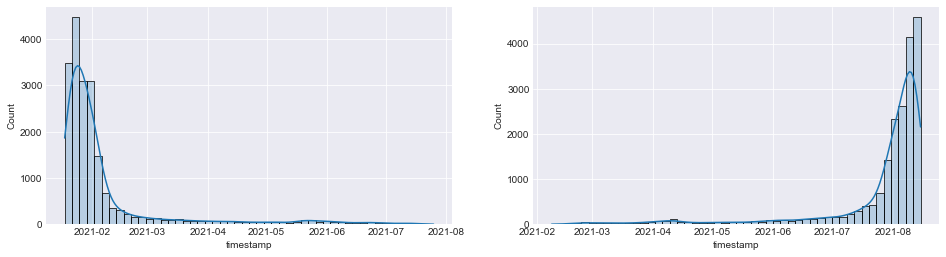

In [ ]:
# Посмотрим на распределение времени начала и конца активности клиентов
fig, axes = plt.subplots(1,2, figsize = (16,4))
sns.histplot(clickstream.groupby('user_id')['timestamp'].min(), bins= 50, ax = axes[0], kde = True, alpha = 0.25, palette = palette)
sns.histplot(clickstream.groupby('user_id')['timestamp'].max(), bins= 50, ax = axes[1], kde = True, alpha = 0.25, palette = palette);

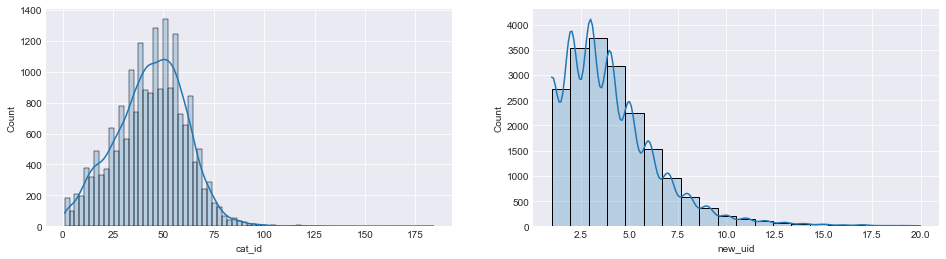

In [ ]:
# Посмотрим на распределение количества уникальных категорий и устройств у каждого клиента
fig, axes = plt.subplots(1,2, figsize = (16,4))
sns.histplot(clickstream.groupby('user_id')['cat_id'].agg(pd.Series.nunique), palette=palette, kde = True, alpha = 0.25, bins = 75, ax = axes[0])
t = clickstream.groupby('user_id')['new_uid'].agg(pd.Series.nunique)
sns.histplot(t[t<21],bins=20,palette=palette, kde = True, alpha = 0.25, ax = axes[1]);

In [ ]:
print('Clickstream by cat_id info:\n', clickstream.groupby('user_id')['cat_id'].agg(pd.Series.nunique).describe(), '\n')
print('Clickstream by new_uid info:\n', clickstream.groupby('user_id')['new_uid'].agg(pd.Series.nunique).describe())

Clickstream by cat_id info:
 count    19623.000000
mean        43.679254
std         17.641016
min          1.000000
25%         32.000000
50%         45.000000
75%         56.000000
max        184.000000
Name: cat_id, dtype: float64 

Clickstream by new_uid info:
 count    19623.000000
mean         4.142333
std          5.156828
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        419.000000
Name: new_uid, dtype: float64


### **Training**

In [20]:
# Перемешаем уникальных user_id клиентов банка 
bank_ids_shuffled = train_matching['bank'].sample(n=train_matching.shape[0], replace=False, random_state=36)
# Отделим одну шестую для валидации (примерно соответствует размеру public/private в первой задаче)
s = len(bank_ids_shuffled)//6
print(len(bank_ids_shuffled), s)

17581 2930


In [21]:
# Соберём обучающую выборку, где на 1 правильный мэтч будет приходиться 10 неправильных

k=10
cor_dict = train_matching.set_index('bank')['rtk'].to_dict()

train_bank_ids = train_matching[(train_matching.bank.isin(bank_ids_shuffled[:-s]))&(train_matching.rtk!=0)]['bank']
train_rtk_ids = train_matching[train_matching.bank.isin(train_bank_ids)]['rtk'].drop_duplicates()
df_train = pd.DataFrame(train_bank_ids, columns=['bank'])
df_train['rtk'] = df_train['bank'].apply(lambda x: [cor_dict[x]] + train_rtk_ids.sample(k, random_state=13).values.tolist() )

valid_bank_ids = train_matching[(train_matching.bank.isin(bank_ids_shuffled[-s:]))&(train_matching.rtk!=0)]['bank']
valid_rtk_ids = train_matching[train_matching.bank.isin(valid_bank_ids)]['rtk'].drop_duplicates()
df_valid = pd.DataFrame(valid_bank_ids, columns=['bank'])
df_valid['rtk'] = df_valid['bank'].apply(lambda x: valid_rtk_ids.values.tolist())

df_train = df_train.explode('rtk')
df_valid = df_valid.explode('rtk')

train_matching['bank+rtk'] = train_matching['bank'].astype('str')+'_'+train_matching['rtk'].astype('str')
df_train['bank+rtk'] = df_train['bank'].astype('str')+'_'+df_train['rtk'].astype('str')
df_valid['bank+rtk'] = df_valid['bank'].astype('str')+'_'+df_valid['rtk'].astype('str')
df_train['target'] = df_train['bank+rtk'].isin(train_matching['bank+rtk']).astype('int')
df_valid['target'] = df_valid['bank+rtk'].isin(train_matching['bank+rtk']).astype('int')

df_train.drop_duplicates('bank+rtk', inplace=True)
df_valid.drop_duplicates('bank+rtk', inplace=True)

df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

In [22]:
print(df_train.shape, df_valid.shape, df_train['target'].mean(), df_valid['target'].mean())
print(df_train.bank.nunique(), df_train.rtk.nunique(), df_train['bank+rtk'].nunique())
print(df_valid.bank.nunique(), df_valid.rtk.nunique(), df_valid['bank+rtk'].nunique())

(134278, 4) (6066369, 4) 0.0909158611239369 0.0004060089321965083
12208 12208 134278
2463 2463 6066369


In [23]:
params = {'nan_mode': 'Min', 'eval_metric': 'MRR', 'iterations': 2000,
'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'od_pval': 0,
'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain',
'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum',
'bayesian_matrix_reg': 0.1000000015, 'l2_leaf_reg': 3, 'random_strength': 1,
'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5,
'pool_metainfo_options': {'tags': {}}, 'subsample': 0.8000000119, 'use_best_model': True,
'od_wait': 100, 'random_seed': 0, 'depth': 4, 'posterior_sampling': False,
'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None',
'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement',
'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1,
'loss_function': 'CrossEntropy', 'learning_rate': 0.02999999933,
'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 10,
'bootstrap_type': 'MVS', 'max_leaves': 16}

In [24]:
clf = CatBoostClassifier()
clf.set_params(**params)
clf.set_params(**{'eval_metric':'Logloss'})
clf.set_params(**{'use_best_model': False})

df_train['predicts'] = 0
df_valid['predicts'] = 0

X_train=df_train.merge(bankclient_embed, how='left', left_on='bank', right_index=True
                          ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)
Y_train=df_train['target']
    
for j in full_list_of_features:
    if j not in X_train.columns:
        X_train[j] = 0
            
X_train = X_train[full_list_of_features].values
    
print(X_train.shape)

clf.fit(X_train, Y_train, verbose=10) 
clf.save_model('model_baseline_puzzle.cbm')
print()
    
df_train['predicts'] = clf.predict_proba(X_train)[:,1]
n = 100
    
train_preds = df_train.loc[:, ['predicts','target', 'bank', 'rtk']].copy(deep=True)
train_preds['pred_rank'] = train_preds.groupby('bank')['predicts'].rank(ascending=False)
precision_train = train_preds[train_preds.pred_rank<=n]['target'].sum()/train_preds.bank.nunique()
mrr_train = 1/train_preds[(train_preds.pred_rank<=n)]['pred_rank']*train_preds[(train_preds.pred_rank<=n)]['target']
mrr_train = mrr_train.sum()/train_preds.bank.nunique()
hm_train = 2/(1/precision_train+1/mrr_train)
print('Train harmonic mean ', round(hm_train,6), ' | mrr ', round(mrr_train,6),' | precision ', round(precision_train,6))
    
del X_train

(134278, 1560)
0:	learn: 0.6454777	total: 324ms	remaining: 10m 46s
10:	learn: 0.3446893	total: 1.57s	remaining: 4m 44s
20:	learn: 0.2063303	total: 2.81s	remaining: 4m 25s
30:	learn: 0.1216187	total: 4.24s	remaining: 4m 29s
40:	learn: 0.0758575	total: 5.97s	remaining: 4m 45s
50:	learn: 0.0488862	total: 7.65s	remaining: 4m 52s
60:	learn: 0.0335325	total: 9.42s	remaining: 4m 59s
70:	learn: 0.0218348	total: 11.5s	remaining: 5m 11s
80:	learn: 0.0155552	total: 13.5s	remaining: 5m 20s
90:	learn: 0.0110443	total: 15.6s	remaining: 5m 26s
100:	learn: 0.0084411	total: 17.5s	remaining: 5m 29s
110:	learn: 0.0063666	total: 19.6s	remaining: 5m 33s
120:	learn: 0.0048705	total: 21.7s	remaining: 5m 36s
130:	learn: 0.0038929	total: 23.8s	remaining: 5m 39s
140:	learn: 0.0032567	total: 25.9s	remaining: 5m 41s
150:	learn: 0.0028265	total: 28s	remaining: 5m 42s
160:	learn: 0.0026030	total: 29.9s	remaining: 5m 41s
170:	learn: 0.0024937	total: 31.7s	remaining: 5m 38s
180:	learn: 0.0023580	total: 33.4s	remainin

In [25]:
clf.save_model('catboost_puzzle.cbm')

In [62]:
# самые полезные фичи
pd.DataFrame({'col':full_list_of_features, 'imp':clf.get_feature_importance()}).sort_values('imp', ascending=False).head(20)

,col,imp
207,count-770,8.173520
226,count-891,6.043245
153,count-493,5.960659
166,count-531,5.870943
99,count-339,5.825482
56,count-215,5.303236
87,count-308,5.021188
46,count-165,4.105866
68,count-251,3.404804
338,count-1459,2.983161


In [63]:
# треть фич не использовалась
(clf.get_feature_importance()==0).sum()

1103

**Валидация на всех валидационных клиентах банка и ртк**

In [26]:
valid_bank_ids = train_matching[(train_matching.bank.isin(bank_ids_shuffled[-s:]))]['bank']
valid_rtk_ids = train_matching[(train_matching.bank.isin(valid_bank_ids))&(train_matching.rtk!=0)]['rtk'].drop_duplicates()
df_valid = pd.DataFrame(valid_bank_ids, columns=['bank'])
df_valid['rtk'] = df_valid['bank'].apply(lambda x: valid_rtk_ids.values.tolist())

df_valid = df_valid.explode('rtk')

df_valid['bank+rtk'] = df_valid['bank'].astype('str')+'_'+df_valid['rtk'].astype('str')
df_valid['target'] = df_valid['bank+rtk'].isin(train_matching['bank+rtk']).astype('int')

df_valid.drop_duplicates('bank+rtk', inplace=True)

df_valid.reset_index(inplace=True, drop=True)

print(df_valid.bank.nunique(), df_valid.rtk.nunique(), df_valid['bank+rtk'].nunique())

2930 2463 7216590


In [27]:
del [clickstream, transactions]
gc.collect()
print_memory()

memory used 5.05 Gb | memory available 6.85 Gb | memory available 57.57 percent


In [28]:
%%time
batch = 50
for i in range(len(valid_bank_ids)//batch+1):
    print(i, end=' ')
    bank_batch = valid_bank_ids[i*batch:(i+1)*batch]
    X_valid=df_valid[df_valid.bank.isin(bank_batch)].merge(bankclient_embed, how='left', left_on='bank', right_index=True
                          ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)
    X_valid = X_valid[full_list_of_features].values
    df_valid.loc[df_valid.bank.isin(bank_batch), 'predicts'] = clf.predict_proba(X_valid)[:,1]
    del X_valid
    
zeros_part = pd.DataFrame({'bank':valid_bank_ids, 'rtk':[0]*len(valid_bank_ids), 'predicts':[5]*len(valid_bank_ids)})
zeros_part['bank+rtk'] = zeros_part['bank'].astype('str')+'_'+zeros_part['rtk'].astype('str')

df_valid = pd.concat([df_valid, zeros_part], axis=0).reset_index(drop=True)
df_valid['target'] = df_valid['bank+rtk'].isin(train_matching['bank+rtk']).astype('int')

df_valid['pred_rank'] = df_valid.groupby('bank')['predicts'].rank(ascending=False)
precision_valid = df_valid[df_valid.pred_rank<=n]['target'].sum()/df_valid.bank.nunique()
mrr_valid = 1/df_valid[(df_valid.pred_rank<=n)]['pred_rank']*df_valid[(df_valid.pred_rank<=n)]['target']
mrr_valid = mrr_valid.sum()/df_valid.bank.nunique()
hm_valid = 2/(1/precision_valid+1/mrr_valid)

print()
print('Task 1 Valid harmonic mean ', round(hm_valid,6), ' | mrr ', round(mrr_valid,6),' | precision ', round(precision_valid,6))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 
Task 1 Valid harmonic mean  0.175474  | mrr  0.160746  | precision  0.193174
Wall time: 4min 37s


In [29]:
# проверяем только для тех, у кого есть мэтчи и без учёта предсказания 0 в качестве наиболее вероятного мэтча

valid_bank_ids = train_matching[(train_matching.bank.isin(bank_ids_shuffled[-s:]))&(train_matching.rtk!=0)]['bank']

ind = (df_valid.pred_rank<=n+1)&(df_valid.pred_rank>1)&(df_valid.bank.isin(valid_bank_ids))
precision_valid = df_valid[ind]['target'].sum()/df_valid.rtk.nunique()
mrr_valid = 1/(df_valid[ind]['pred_rank']-1)*df_valid[ind]['target']
mrr_valid = mrr_valid.sum()/df_valid.rtk.nunique()
hm_valid = 2/(1/precision_valid+1/mrr_valid)

print()
print('Task 2 Valid harmonic mean ', round(hm_valid,6), ' | mrr ', round(mrr_valid,6),' | precision ', round(precision_valid,6))


Task 2 Valid harmonic mean  0.003589  | mrr  0.001878  | precision  0.040179


**Сбор пазла**

In [30]:
puzzle_bank_ids = puzzle['bank'].drop_duplicates()
puzzle_rtk_ids = puzzle['rtk'].drop_duplicates()
df_puzzle = pd.DataFrame(puzzle_bank_ids, columns=['bank'])
df_puzzle['rtk'] = df_puzzle['bank'].apply(lambda x: puzzle_rtk_ids.values.tolist())

df_puzzle = df_puzzle.explode('rtk')

df_puzzle.reset_index(inplace=True, drop=True)

In [31]:
%%time
batch = 50
for i in range(len(puzzle_bank_ids)//batch+1):
    print(i, end=' ')
    bank_batch = puzzle_bank_ids[i*batch:(i+1)*batch]
    X_puzzle=df_puzzle[df_puzzle.bank.isin(bank_batch)].merge(bankclient_embed, how='left', left_on='bank', right_index=True
                          ).merge(clickstream_embed, how='left', left_on='rtk', right_index=True).fillna(0)
    X_puzzle = X_puzzle[full_list_of_features].values
    df_puzzle.loc[df_puzzle.bank.isin(bank_batch), 'predicts'] = clf.predict_proba(X_puzzle)[:,1]
    del X_puzzle
    
df_puzzle['pred_rank'] = df_puzzle.groupby('bank')['predicts'].rank(ascending=False)

print()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
Wall time: 16min 47s


In [32]:
df_puzzle[df_puzzle.pred_rank<=100]['bank'].value_counts().value_counts()
## там где 99 хорошо бы добавить на всякий случай !!!!

100    4952
Name: bank, dtype: int64

In [33]:
sub = df_puzzle[df_puzzle.pred_rank<=100].copy(deep=True)
sub['rtk'] = all_dicts['rtk_le'].inverse_transform(sub['rtk'].astype(int)-1)
sub['bank'] = all_dicts['bank_le'].inverse_transform(sub['bank']-1)

sub = sub.pivot_table(index='bank', values='rtk', aggfunc=list)
sub['rtk'] = sub['rtk'].apply(lambda x: str(x))
sub = sub.replace("'", '', regex=True)
sub.rename({'rtk':'rtk_list'}, axis=1).to_csv('sub_puzzle_baseline.csv', index=True)